In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_excel("../../EsaveExportBig.xls") # local file. use above if not you are not me
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
datetime = df.pop("datetime")
df = df.dropna(axis=1, how="any")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))
channels = df.shape[1] # for later

In [3]:
df = df.iloc[:,:10]
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# grangers_causation_matrix(df, variables = df.columns)

In [13]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df)

In [5]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [6]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "707057500068119547" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9604
 No. Lags Chosen       = 55
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "707057500068755066" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.1564
 No. Lags Chosen       = 51
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ESAVE_193681-980396002_EAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

(43848,)
(43848,)
    Augmented Dickey-Fuller Test on "averaged-24hr" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9604
 No. Lags Chosen       = 55
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


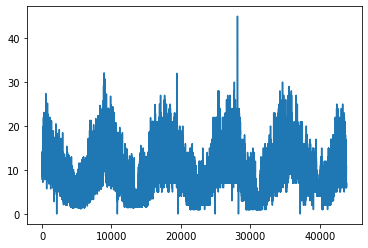

In [7]:
x = df.values[:,0]
print(x.shape)
avgResult = np.average(x.reshape(-1, 1), axis=1)
print(avgResult.shape)
plt.plot(avgResult)
adfuller_test(avgResult, name="averaged-24hr")

In [8]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  17.006596314210743
BIC :  17.02839326209418
FPE :  24314813.079058282
HQIC:  17.013466026085748 

Lag Order = 2
AIC :  16.029784513977802
BIC :  16.071397708851904
FPE :  9154759.94640882
HQIC:  16.042899697139884 

Lag Order = 3
AIC :  15.893560336437663
BIC :  15.954990578187605
FPE :  7988873.657598822
HQIC:  15.912921256308104 

Lag Order = 4
AIC :  15.765359807835395
BIC :  15.846607896397515
FPE :  7027628.123204579
HQIC:  15.790966729852915 

Lag Order = 5
AIC :  15.675623936047577
BIC :  15.776690671409394
FPE :  6424465.191095615
HQIC:  15.707477125668328 

Lag Order = 6
AIC :  15.598588330558531
BIC :  15.719474512758744
FPE :  5948135.389637868
HQIC:  15.6366880532561 

Lag Order = 7
AIC :  15.491824926790779
BIC :  15.632531355919273
FPE :  5345817.059944288
HQIC:  15.536171448056193 

Lag Order = 8
AIC :  15.403347898715964
BIC :  15.563875374913813
FPE :  4893155.455493886
HQIC:  15.453941484057687 

Lag Order = 9
AIC :  15.318216567133614
BIC :  15.4

In [9]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,27.28,27.28,7.014e+11,27.28
1,17.01,17.03,2.430e+07,17.01
2,16.03,16.07,9.149e+06,16.04
3,15.89,15.95,7.982e+06,15.91
4,15.76,15.85,7.020e+06,15.79
5,15.67,15.78,6.418e+06,15.71
6,15.60,15.72,5.942e+06,15.64
7,15.49,15.63,5.342e+06,15.54
8,15.40,15.56,4.892e+06,15.45
9,15.32,15.50,4.493e+06,15.37


In [10]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Feb, 2022
Time:                     23:38:02
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    16.0714
Nobs:                     43846.0    HQIC:                   16.0429
Log likelihood:          -973359.    FPE:                9.15476e+06
AIC:                      16.0298    Det(Omega_mle):     9.11103e+06
--------------------------------------------------------------------
Results for equation 707057500068119547
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.641579         0.018076           35.493           0.000
L1.707057500068119547                 0.551062         0.005542           99.436

In [15]:
def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

707057500068119547 : 2.01
707057500068755066 : 1.96
ESAVE_193681-980396002_EAN : 2.02
707057500068789658 : 2.01
707057500068425556 : 2.03
707057500068402960 : 2.0
707057500068104048 : 1.93
707057500068744237 : 2.01
707057500068750269 : 2.01
707057500067764427 : 1.95


[[ 7.  3.  7.  6.  6. 13. 11. 16.  3.  7.]
 [ 7.  3.  7.  5.  7. 11. 10. 14.  2.  8.]]
[[ 6.99301109  3.32061863  7.49294272  5.2426291   6.4236936  10.19729629
   9.77865402 13.71543355  3.89415883  7.33058513]]


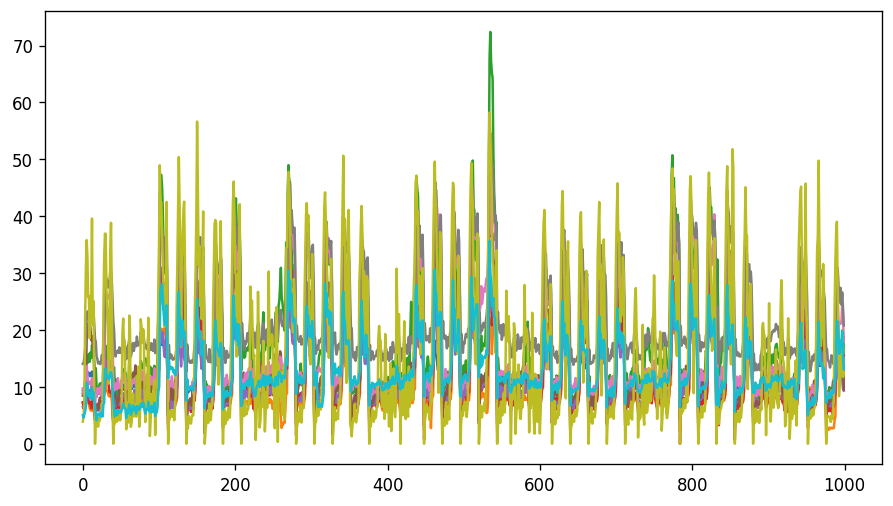

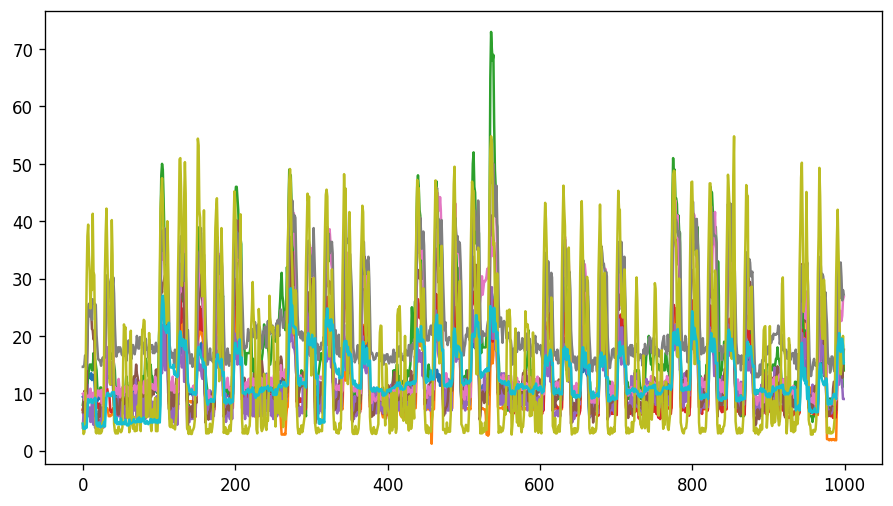

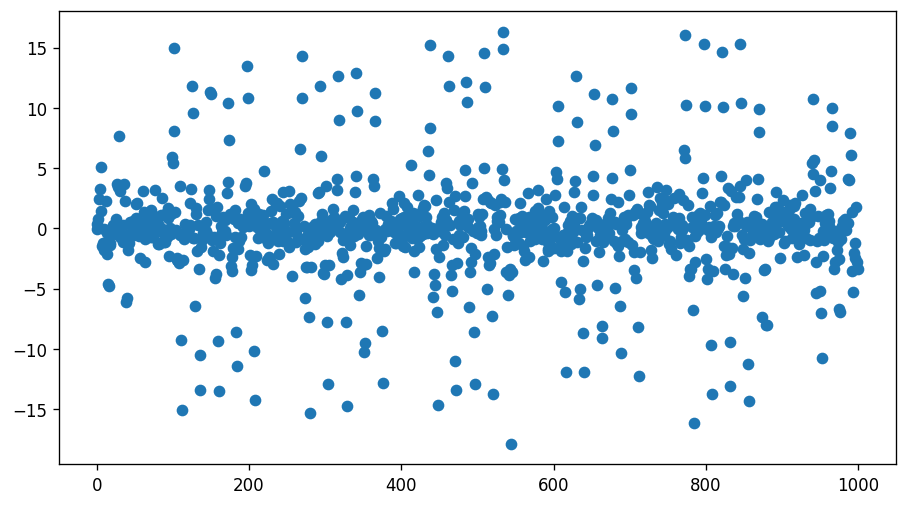

In [54]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df.values[-lag_order:]
print(forecast_input)

fc = model_fitted.forecast(y=forecast_input, steps=1)
plt.plot(fc)
print(fc)


fcs = []
for i in range(1000):
    forecast_input = df.values[i:i+lag_order]
    fc = model_fitted.forecast(y=forecast_input, steps=1)
    fc[np.where(fc < 0)] = 0
    fcs.append(fc.reshape(10))
    
fcs = np.stack(fcs)
plt.plot(fcs)
plt.show()
plt.plot(df.values[:1000])
plt.show()
res = np.mean(fcs - df.values[:1000], axis=1)
plt.scatter(range(1000), res)
plt.show()